# **Text Summarization Using a Transformer Model**

This notebook demonstrates the implementation of a [sequence-to-sequence Transformer model](https://huggingface.co/learn/nlp-course/en/chapter1/7) for the task of text summarization, a field within Natural Language Processing (NLP) that involves creating a shorter version of a document or article that captures all the essential information. Specifically, an abstractive summarization model will be developed, which generates new text that synthesizes the most relevant information. The model will be trained using the [Extreme Summarization (XSum) Dataset](https://huggingface.co/datasets/EdinburghNLP/xsum), which contains BBC news articles (mostly quite extensive) along with their corresponding concise summaries in a single sentence.

**For a more advanced implementation, visit my next [notebook](https://github.com/JersonGB22/Summarization-TensorFlow/blob/main/models/Summarization_T5_XSum.ipynb), where the [T5 model](https://huggingface.co/docs/transformers/model_doc/t5) is fine-tuned to achieve better results.**

## **Imports**

In [ ]:
# Install the Hugging Face datasets library
!pip install datasets -q

# Install the necessary library to evaluate the summary
!pip install rouge_score -q

In [3]:
import tensorflow as tf
from datasets import load_dataset, load_metric
import numpy as np
import re
import plotly.graph_objects as go
from google.colab import drive
from IPython.core.display import HTML
import textwrap
from tqdm.auto import tqdm

## **Parameters**

In [ ]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
batch_size = 256
buffer_size = 1024
AUTOTUNE = tf.data.AUTOTUNE
SEED = 123
embedding_dim = 256
vocab_size = 50000
context_max_length = 512
target_max_length = 64
epochs = 20

## **Load and Preprocess the Dataset**

In [ ]:
dataset = load_dataset("xsum", trust_remote_code=True)
dataset

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 204045
    })
    validation: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11332
    })
    test: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11334
    })
})

In [ ]:
# See an example of the training dataset
dataset["train"][0]

{'document': 'The full cost of damage in Newton Stewart, one of the areas worst affected, is still being assessed.\nRepair work is ongoing in Hawick and many roads in Peeblesshire remain badly affected by standing water.\nTrains on the west coast mainline face disruption due to damage at the Lamington Viaduct.\nMany businesses and householders were affected by flooding in Newton Stewart after the River Cree overflowed into the town.\nFirst Minister Nicola Sturgeon visited the area to inspect the damage.\nThe waters breached a retaining wall, flooding many commercial properties on Victoria Street - the main shopping thoroughfare.\nJeanette Tate, who owns the Cinnamon Cafe which was badly affected, said she could not fault the multi-agency response once the flood hit.\nHowever, she said more preventative work could have been carried out to ensure the retaining wall did not fail.\n"It is difficult but I do think there is so much publicity for Dumfries and the Nith - and I totally apprecia

### **Text Tokenization**

For tokenization, the [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer is used for both articles (contexts) and summaries (targets). This layer encodes text into frequency-ordered indices, following the padding and unknown tokens, up to the defined vocabulary size (`vocab_size`). The `standardize` argument allows for passing a text preprocessing function, where `[START]` and `[END]` tokens are added to indicate the beginning and end of the sequence, respectively. Since the Transformer model is large and the training dataset is substantial, it is trained on a Colab TPU to significantly improve training time. Consequently, sequences need to be of uniform length, for which the `output_sequence_length` argument is used to truncate or pad as necessary.

In [ ]:
# Create a custom standardization function

def preprocessing(text):
  # Convert all text to lowercase
  text = tf.strings.lower(text)
  # Removing line breaks
  text = tf.strings.regex_replace(text, r"\n+", " ")
  # Remove hyperlinks
  text = tf.strings.regex_replace(text, r"https?://[^\s\n\r]+|www\.[^\s\n\r]+", "")
  # Remove Twitter usernames and email addresses
  text = tf.strings.regex_replace(text, r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,7}\b", "")
  text = tf.strings.regex_replace(text, r"@\w+", "")
  # Keep only alphabetic characters and certain punctuation marks
  text = tf.strings.regex_replace(text, r"[-—_/]", " ") #For compound words
  text = tf.strings.regex_replace(text, r"[^ a-z.,;:?!]", "")
  # Add spaces around punctuation
  text = tf.strings.regex_replace(text, r"[.,;:?!]", r" \0 ")
  # Remove all redundant white spaces
  text = tf.strings.regex_replace(tf.strings.strip(text), r"\s+", " ")
  # Add start and end tokens to the text
  text = tf.strings.join(["[START]", text, "[END]"], separator=" ")
  return text

In [ ]:
# Example of text preprocessing
id = 0
example = dataset["train"][id]
example_context = tf.constant(example["document"])
example_target = tf.constant(example["summary"])

print(f"Unstandardized Context:\n{example_context.numpy().decode('utf-8')}\n")
print(f"Standardized Context:\n{textwrap.fill(preprocessing(example_context).numpy().decode('utf-8'), width=150)}\n\n")

print(f"Unstandardized Target:\n{example_target.numpy().decode('utf-8')}\n")
print(f"Standardized Target:\n{textwrap.fill(preprocessing(example_target).numpy().decode('utf-8'), width=150)}")

Unstandardized Context:
The full cost of damage in Newton Stewart, one of the areas worst affected, is still being assessed.
Repair work is ongoing in Hawick and many roads in Peeblesshire remain badly affected by standing water.
Trains on the west coast mainline face disruption due to damage at the Lamington Viaduct.
Many businesses and householders were affected by flooding in Newton Stewart after the River Cree overflowed into the town.
First Minister Nicola Sturgeon visited the area to inspect the damage.
The waters breached a retaining wall, flooding many commercial properties on Victoria Street - the main shopping thoroughfare.
Jeanette Tate, who owns the Cinnamon Cafe which was badly affected, said she could not fault the multi-agency response once the flood hit.
However, she said more preventative work could have been carried out to ensure the retaining wall did not fail.
"It is difficult but I do think there is so much publicity for Dumfries and the Nith - and I totally apprec

In [ ]:
# It is necessary to adapt `TextVectorization` in batches due to the large size of the training dataset
contexts = tf.data.Dataset.from_tensor_slices(dataset["train"]["document"])
targets = tf.data.Dataset.from_tensor_slices(dataset["train"]["summary"])
data_adapt = contexts.concatenate(targets).batch(batch_size)

context_tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,
    standardize=preprocessing,
    output_sequence_length=context_max_length
)
context_tokenizer.adapt(data_adapt)
vocab = np.array(context_tokenizer.get_vocabulary())
vocab_size = context_tokenizer.vocabulary_size()

target_tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,
    standardize=preprocessing,
    output_sequence_length=target_max_length+1,
    vocabulary=vocab
)

print(vocab_size)
print(vocab[:30])

# Delete these datasets to free up memory
del contexts, targets, data_adapt

50000
['' '[UNK]' 'the' '.' ',' 'to' 'a' 'of' 'and' 'in' 'on' 'for' 'is' 'was'
 'that' 'it' 'said' 'he' 'with' 'at' 'by' 'have' 'as' 'has' 'be' 'from'
 '[START]' '[END]' 'but' 'are']


### **Create the training and validation datasets using ``tf.data``**

In [ ]:
def vectorize_text(contexts, targets):
  contexts = context_tokenizer(contexts)
  targets = target_tokenizer(targets)
  targets_in = targets[:-1]
  targets_out = targets[1:]
  return (contexts, targets_in), targets_out

In [ ]:
train_dataset= tf.data.Dataset.from_tensor_slices(
    (dataset["train"]["document"], dataset["train"]["summary"])
)
val_dataset= tf.data.Dataset.from_tensor_slices(
    (dataset["validation"]["document"], dataset["validation"]["summary"])
)

print(len(train_dataset), len(val_dataset))

train_dataset = (
    train_dataset.
    map(vectorize_text, num_parallel_calls=AUTOTUNE).
    shuffle(buffer_size, seed=SEED).
    batch(batch_size, drop_remainder=True).
    prefetch(AUTOTUNE)
)

val_dataset = (
    val_dataset.
    map(vectorize_text, num_parallel_calls=AUTOTUNE).
    batch(batch_size, drop_remainder=True).
    prefetch(AUTOTUNE)
)

204045 11332


In [ ]:
# Viewing a training batch
for (inputs, targets_in), targets_out in train_dataset.take(1):
  print(inputs[:2], "\n")
  print(targets_in[:2], "\n")
  print(targets_out[:2])

tf.Tensor(
[[  26    6  293 ...    0    0    0]
 [  26 2608    4 ...    0    0    0]], shape=(2, 512), dtype=int64) 

tf.Tensor(
[[   26  2018   939  4067    21   160   805    19   457   437  6141     4
    192   136   229     4    42    40   523     5   626    76  1294     4
   2264   148     3    27     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [   26   239   154    49  6093  2608   676   730  4388 10443     1     9
   1497  2725     5   175    64   126 12786   621    19     2 22164   246
      3    27     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]], shape=(2, 64), dtype=int64) 

tf.Tensor(
[[ 2018   939  4067    21   160   

## **Creation of the Transformer Model**

![Transformer Model](https://www.tensorflow.org/images/tutorials/transformer/transformer.png)

*Source: TensorFlow*

### **Embedding Layer with Positional Encoding**

Given a sequence of tokens, both input tokens (articles) and target tokens (summaries) are transformed into vectors using the Embedding layer. Additionally, the attention layers in the model treat their input as a set of vectors, without considering order. Since the model lacks any recurrent or convolutional layers, it requires a mechanism to determine the order of words. To address this, a set of sine and cosine functions at different frequencies are added to the embedding vectors. The formulas for calculating the positional encoding are as follows:

$$PE_{(pos, 2i)} = \sin\left(\frac{pos}{{10000}^{\frac{2i}{d}}}\right)$$
$$PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{{10000}^{\frac{2i}{d}}}\right)$$

In [ ]:
@tf.keras.saving.register_keras_serializable()
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, model_max_length, embedding_dim):
    super().__init__()
    self.embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        mask_zero=True #Indicate that the value 0 is a padding value that should be masked in all layers of the model
    )
    self.pos_encoding = self.positional_encoding(model_max_length, embedding_dim)

  def call(self, x):
    x = self.embedding(x)
    length, embedding_dim = tf.shape(x)[1], tf.shape(x)[2]
    # Scale the embedding vectors by multiplying them by the square root of the embedding dimension
    x *= tf.sqrt(tf.cast(embedding_dim, tf.float32))
    x += self.pos_encoding[None, :length]
    return x

  def positional_encoding(self, model_max_length, embedding_dim):
    positions = np.arange(model_max_length)[:, None]
    k = np.arange(embedding_dim)[None, :]
    i = k // 2

    angle_rates = 1 / np.power(10000, (2*i) / embedding_dim)
    angle_rads = positions * angle_rates
    angle_rads[:, ::2] = np.sin(angle_rads[:, ::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = tf.cast(angle_rads, tf.float32)

    return pos_encoding

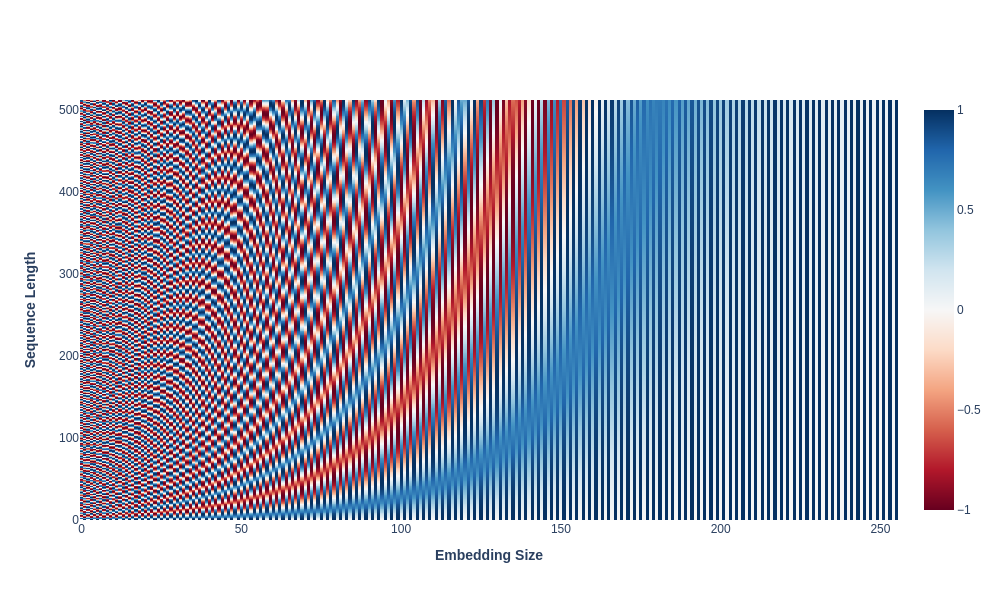

In [ ]:
# Visualize the Model's Positional Encodings
pos_encoding = PositionalEmbedding(
    vocab_size,
    context_max_length,
    embedding_dim
).pos_encoding


fig = go.Figure(data=go.Heatmap(
    z=pos_encoding,
    colorscale="RdBu"
))

fig.update_layout(
    width=1000,
    height=600,
    xaxis_title="<b>Embedding Size</b>",
    yaxis_title="<b>Sequence Length</b>"
)

# Interactive graphic
fig.show()
# Static image for GitHub
fig.show(renderer="png")

It can be seen that each row represents a positional encoding, and no two rows are identical.

### **Feed Forward Network**

In [ ]:
def FeedForward(embedding_dim, dropout, name="feed_forward"):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(embedding_dim, activation="relu"),
      tf.keras.layers.Dense(embedding_dim),
      tf.keras.layers.Dropout(dropout)
  ], name=name)

### **The Encoder**

In [ ]:
def EncoderLayer(num_heads, embedding_dim, dropout, name="encoder_layer"):
  query = tf.keras.Input(shape=(None, embedding_dim))

  self_attention = tf.keras.layers.MultiHeadAttention(num_heads, embedding_dim, dropout=dropout, name="SelfAttention")(
      query=query,
      value=query,
      key=query
  )
  x = tf.keras.layers.Add()([query, self_attention])
  x = tf.keras.layers.LayerNormalization()(x)

  name_ff = name.split("_")[0] + "_feed_forward_" + name.split("_")[-1]
  feed_forward = FeedForward(embedding_dim, dropout, name=name_ff)(x)
  x = tf.keras.layers.Add()([x, feed_forward])
  x = tf.keras.layers.LayerNormalization()(x)

  model = tf.keras.Model(inputs=query, outputs=x, name=name)
  return model

In [ ]:
def Encoder(vocab_size, model_max_length, embedding_dim, dropout, num_layers, num_heads):
  encoder_input = tf.keras.Input(shape=(None,), name="encoder_input")
  x = PositionalEmbedding(vocab_size, model_max_length, embedding_dim)(encoder_input)
  x = tf.keras.layers.Dropout(dropout)(x)

  encoder_layers = [
      EncoderLayer(num_heads, embedding_dim, dropout, name=f"encoder_layer_{i+1}")
      for i in range(num_layers)
  ]
  for layer in encoder_layers:
    x = layer(x)

  model = tf.keras.Model(inputs=encoder_input, outputs=x, name="Encoder")
  return model

### **The Decoder**

In [ ]:
def DecoderLayer(num_heads, embedding_dim, dropout, name="decoder_layer"):
  query = tf.keras.Input(shape=(None, embedding_dim))
  encoder_output = tf.keras.Input(shape=(None, embedding_dim), name="encoder_output")

  causal_self_attention = tf.keras.layers.MultiHeadAttention(num_heads, embedding_dim, dropout=dropout, name="CausalSelfAttention")(
      query=query,
      value=query,
      key=query,
      use_causal_mask=True #A mask that prevents the layer from attending to future tokens in the sequence
  )
  x = tf.keras.layers.Add()([query, causal_self_attention])
  x = tf.keras.layers.LayerNormalization()(x)

  cross_attention = tf.keras.layers.MultiHeadAttention(num_heads, embedding_dim, dropout=dropout, name="CrossAttention")(
      query=x,
      value=encoder_output,
      key=encoder_output
  )
  x = tf.keras.layers.Add()([x, cross_attention])
  x = tf.keras.layers.LayerNormalization()(x)

  name_ff = name.split("_")[0] + "_feed_forward_" + name.split("_")[-1]
  feed_forward = FeedForward(embedding_dim, dropout, name=name_ff)(x)
  x = tf.keras.layers.Add()([x, feed_forward])
  x = tf.keras.layers.LayerNormalization()(x)

  model = tf.keras.Model(inputs=[query, encoder_output], outputs=x, name=name)
  return model

In [ ]:
def Decoder(vocab_size, model_max_length, embedding_dim, dropout, num_layers, num_heads):
  decoder_input = tf.keras.Input(shape=(None,), name="decoder_input")
  encoder_output = tf.keras.Input(shape=(None, embedding_dim), name="encoder_output")

  x = PositionalEmbedding(vocab_size, model_max_length, embedding_dim)(decoder_input)
  x = tf.keras.layers.Dropout(dropout)(x)

  decoder_layers = [
      DecoderLayer(num_heads, embedding_dim, dropout, name=f"decoder_layer_{i+1}")
      for i in range(num_layers)
  ]
  for layer in decoder_layers:
    x = layer([x, encoder_output])

  model = tf.keras.Model(inputs=[decoder_input, encoder_output], outputs=x, name="Decoder")
  return model

### **The Transformer Model**

In [ ]:
def Transformer(context_vocab_size, target_vocab_size, model_max_length,
                embedding_dim, dropout, num_layers, num_heads):

  encoder_input = tf.keras.Input(shape=(None,), name="encoder_input")
  decoder_input = tf.keras.Input(shape=(None,), name="decoder_input")

  x = Encoder(context_vocab_size, model_max_length, embedding_dim, dropout, num_layers, num_heads)(encoder_input)
  x = Decoder(target_vocab_size, model_max_length, embedding_dim, dropout, num_layers, num_heads)([decoder_input, x])
  x = tf.keras.layers.Dense(target_vocab_size)(x)

  model = tf.keras.Model(inputs=[encoder_input, decoder_input], outputs=x, name="Transformer")
  return model

## **Model Compilation and Training**

In this case, during model compilation, using `SparseCategoricalCrossentropy` with the `ignore_class=0` argument to mask the padding token is not feasible because the Colab TPU does not support this argument. Therefore, a custom loss function and a custom accuracy metric are implemented to handle padding masking appropriately. Additionally, since the Transformer model is trained from scratch, a custom learning rate for the Adam optimizer is required.

**Custom Loss and Accuracy**

In [ ]:
def masked_loss(labels, logits):
  loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True,
      reduction=tf.keras.losses.Reduction.NONE
  )

  loss = loss_fn(labels, logits)
  mask = tf.cast(labels != 0, loss.dtype)
  loss *= mask

  return tf.reduce_sum(loss) / tf.reduce_sum(mask)


def masked_accuracy(y_true, y_pred):
  y_pred = tf.cast(tf.argmax(y_pred, axis=-1), y_true.dtype)
  mask = tf.cast(y_true != 0, tf.float32)
  accuracy = tf.cast(y_true == y_pred, tf.float32)
  accuracy *= mask

  return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

**Optimizer with a Custom Learning Rate Scheduler**

In [ ]:
@tf.keras.saving.register_keras_serializable()
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, embedding_dim, warmup_steps=4000):
    super().__init__()
    self.embedding_dim = tf.cast(embedding_dim, tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    return tf.math.rsqrt(self.embedding_dim) * tf.math.minimum(arg1, arg2)

  def get_config(self):
    return {
        "embedding_dim": self.embedding_dim.numpy(),
        "warmup_steps": self.warmup_steps
    }

In [ ]:
learning_rate = CustomSchedule(embedding_dim)
optimizer = tf.keras.optimizers.Adam(
    learning_rate,
    beta_1=0.9,
    beta_2=0.98,
    epsilon=1e-9
)

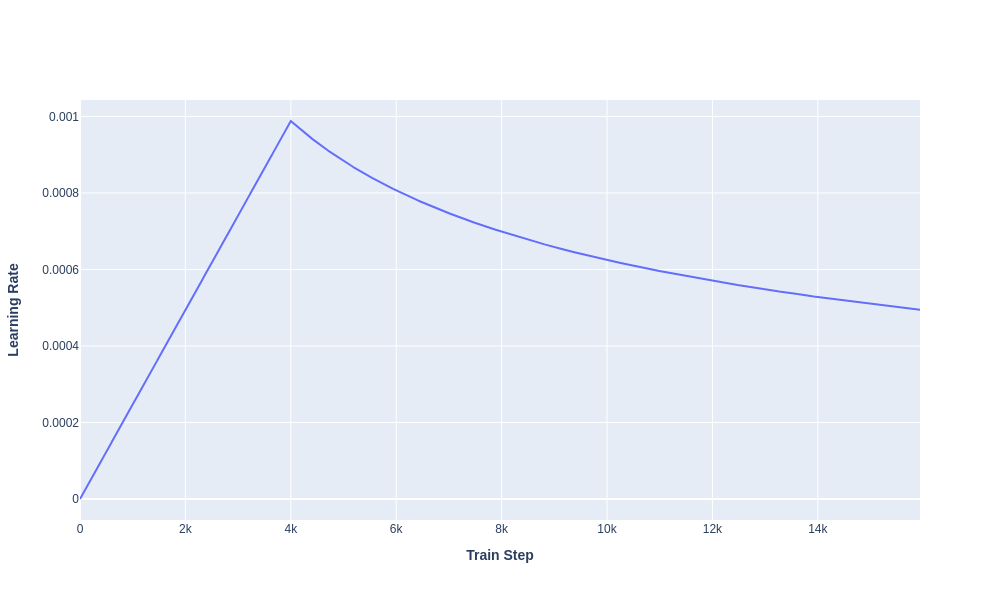

In [ ]:
# Visualize the Custom Learning Rate
total_steps = len(train_dataset) * epochs
total_steps = tf.range(total_steps, dtype=tf.float32)

fig = go.Figure()
fig.add_trace(go.Scatter(x=total_steps, y=learning_rate(total_steps), mode="lines"))
fig.update_layout(
    width=1000,
    height=600,
    xaxis_title="<b>Train Step</b>",
    yaxis_title="<b>Learning Rate</b>"
)

fig.show()
fig.show(renderer="png")

### **Model Compilation**

In [ ]:
# TPU setup
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="local")
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)
  print("TPU initialized:")
  print("All devices: ", tf.config.list_logical_devices("TPU"))
except ValueError:
  print("TPU not found")

TPU initialized:
All devices:  [LogicalDevice(name='/device:TPU:0', device_type='TPU'), LogicalDevice(name='/device:TPU:1', device_type='TPU'), LogicalDevice(name='/device:TPU:2', device_type='TPU'), LogicalDevice(name='/device:TPU:3', device_type='TPU'), LogicalDevice(name='/device:TPU:4', device_type='TPU'), LogicalDevice(name='/device:TPU:5', device_type='TPU'), LogicalDevice(name='/device:TPU:6', device_type='TPU'), LogicalDevice(name='/device:TPU:7', device_type='TPU')]


In [ ]:
tf.keras.backend.clear_session() #Clearing Keras memory
tf.random.set_seed(SEED) #For reproducibility

with strategy.scope():
  model = Transformer(
      vocab_size,
      vocab_size,
      context_max_length,
      embedding_dim,
      dropout=0.1,
      num_layers=4,
      num_heads=8
  )
  model.compile(
    optimizer=optimizer,
    loss=masked_loss,
    metrics=[masked_accuracy]
  )

model.summary()

Model: "Transformer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, None)]               0         []                            
                                                                                                  
 decoder_input (InputLayer)  [(None, None)]               0         []                            
                                                                                                  
 Encoder (Functional)        (None, None, 256)            2174464   ['encoder_input[0][0]']       
                                                          0                                       
                                                                                                  
 Decoder (Functional)        (None, None, 256)            3016089   ['decoder_input[0][0

**Model Architecture**

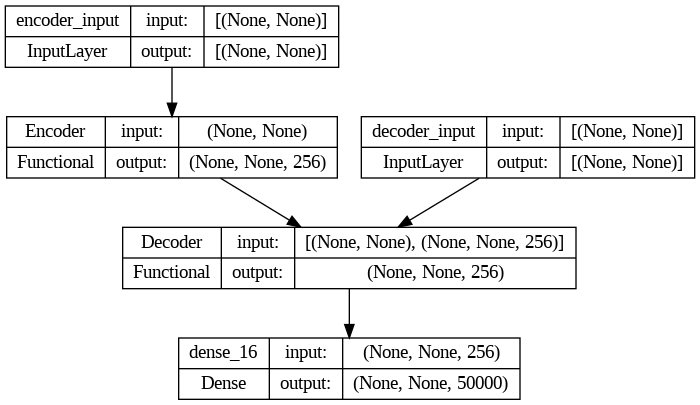

In [ ]:
tf.keras.utils.plot_model(model, show_layer_names=True, show_shapes=True)

**Detailed Architecture of the Transformer Model**

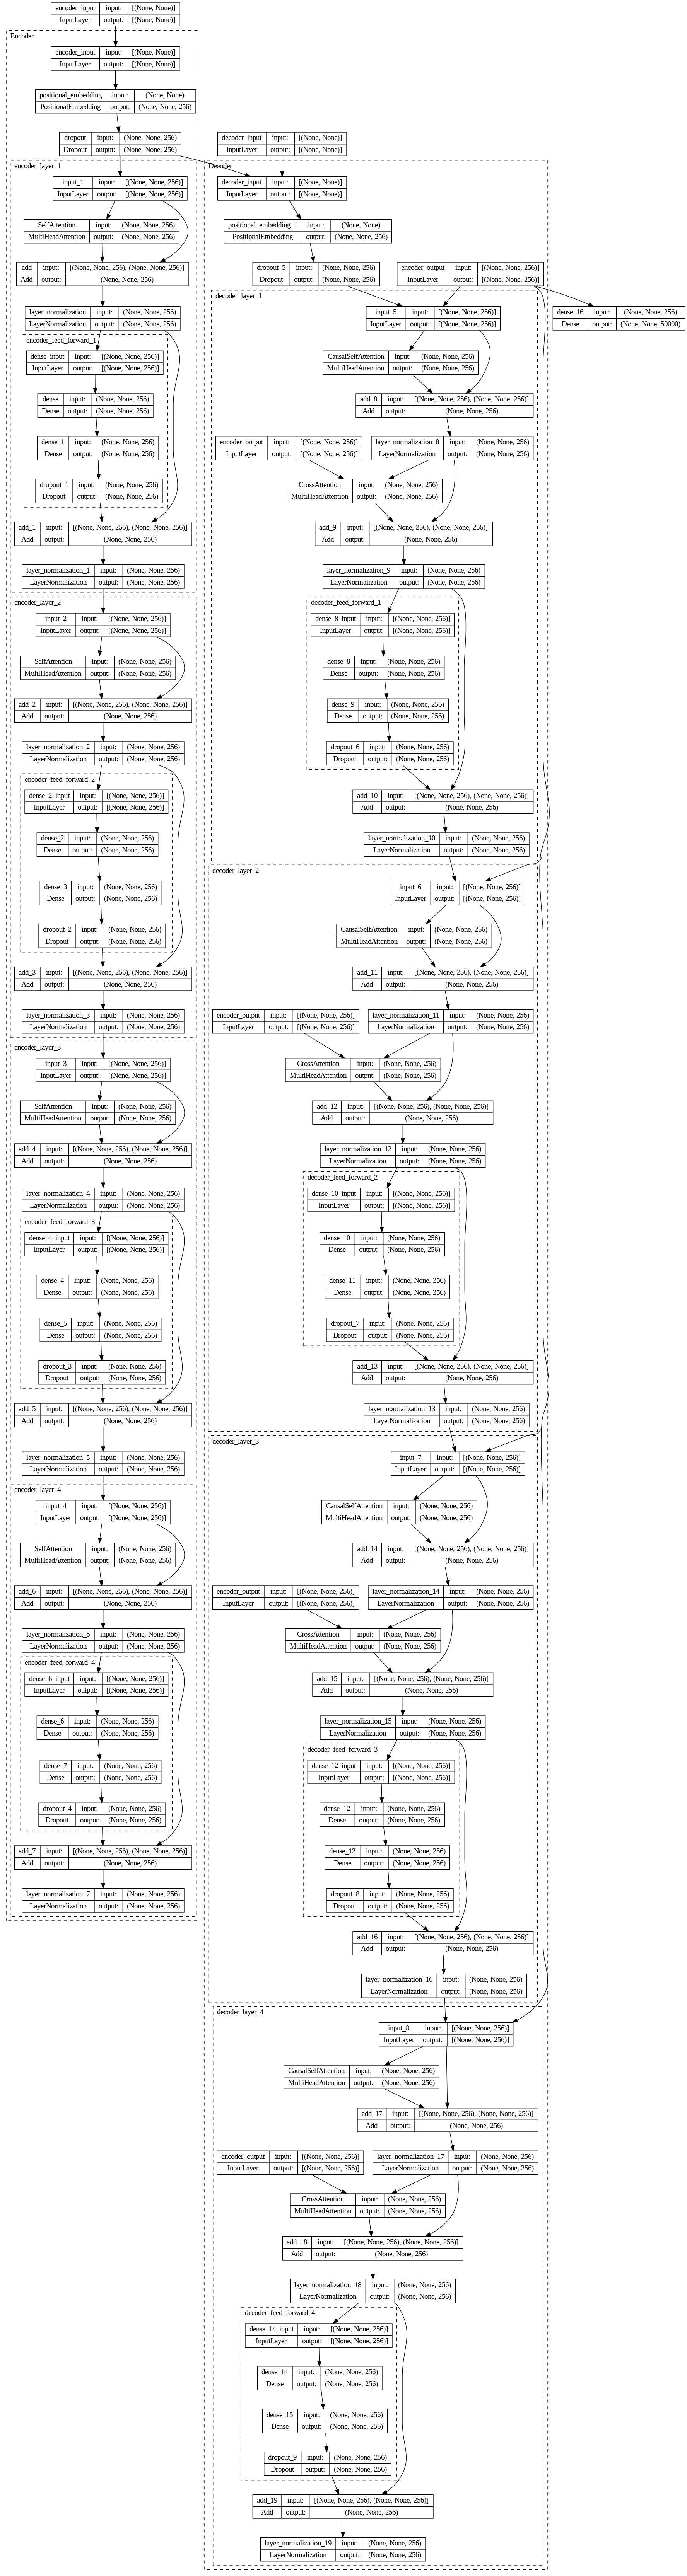

In [ ]:
tf.keras.utils.plot_model(model, show_layer_names=True, show_shapes=True, expand_nested=True)

### **Train the model**

In [ ]:
# Callback to stop training early if accuracy does not increase for 2 epochs
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_masked_accuracy",
    patience=2,
    mode="max",
    restore_best_weights=True
)

In [ ]:
tf.random.set_seed(SEED)
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=[callback])

Epoch 1/20
797/797 [==============================] - 378s 381ms/step - loss: 7.6450 - masked_accuracy: 0.1281 - val_loss: 5.5720 - val_masked_accuracy: 0.2169
Epoch 2/20
797/797 [==============================] - 292s 366ms/step - loss: 4.9649 - masked_accuracy: 0.2562 - val_loss: 4.4161 - val_masked_accuracy: 0.2980
Epoch 3/20
797/797 [==============================] - 287s 360ms/step - loss: 4.1438 - masked_accuracy: 0.3166 - val_loss: 3.8660 - val_masked_accuracy: 0.3410
Epoch 4/20
797/797 [==============================] - 291s 365ms/step - loss: 3.6774 - masked_accuracy: 0.3540 - val_loss: 3.5849 - val_masked_accuracy: 0.3670
Epoch 5/20
797/797 [==============================] - 289s 363ms/step - loss: 3.4019 - masked_accuracy: 0.3777 - val_loss: 3.4559 - val_masked_accuracy: 0.3787
Epoch 6/20
797/797 [==============================] - 287s 360ms/step - loss: 3.1845 - masked_accuracy: 0.3983 - val_loss: 3.3502 - val_masked_accuracy: 0.3916
Epoch 7/20
797/797 [====================

**Save model**

In [ ]:
trained_model_path = "/content/drive/MyDrive/models/Summarization_Transformer_XSum.keras"

In [ ]:
model.save(trained_model_path)

## **Model Evaluation**

### **With conventional Accuracy**

In [ ]:
print(model.evaluate(train_dataset, verbose=0))
print(model.evaluate(val_dataset, verbose=0))

[2.237126111984253, 0.5140340924263]
[3.3223695755004883, 0.40385010838508606]


Conventional accuracy (`train_dataset: 51.4%, val_dataset: 40.39%`) does not accurately reflect the model's true performance but serves as a useful approximation during training to gauge how well the model is performing in text summarization. For a more precise evaluation, the **ROUGE** metric will be used.

In [ ]:
# Function to plot the metrics
def plot_metrics(history=history, metric="loss", renderer=None, epochs=len(history.history["loss"])):
  losses = history.history[metric]
  val_losses = history.history[f"val_{metric}"]
  list_epochs = np.arange(1, epochs+1)
  metric = " ".join([w.capitalize() for w in metric.split("_")])

  fig=go.Figure()
  fig.add_trace(go.Scatter(x=list_epochs, y=losses, name=metric, line=dict(color="blue", width=2)))
  fig.add_trace(go.Scatter(x=list_epochs, y=val_losses, name=f"Val {metric}", line=dict(color="#FF6600", width=2)))
  fig.update_xaxes(title_text="Epoch")
  fig.update_yaxes(title_text=metric)
  fig.update_layout(title=f"Evolution of {metric} across Epochs",
                    title_font=dict(size=20),
                    title_x=0.5,
                    height=500,
                    width=1200)

  fig.show(renderer)

**Graphs of the metrics**

In [ ]:
plot_metrics()
plot_metrics(metric="masked_accuracy")

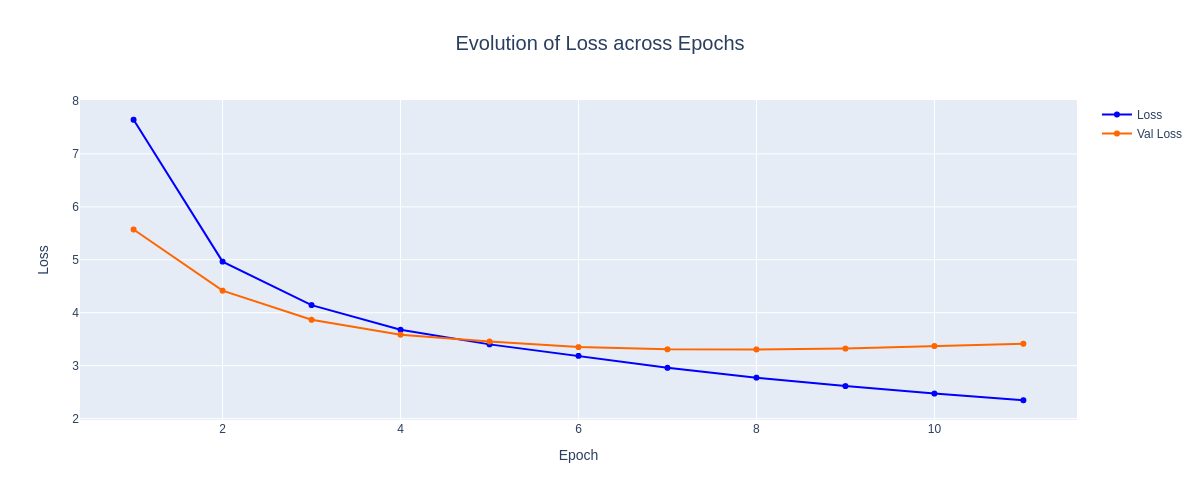

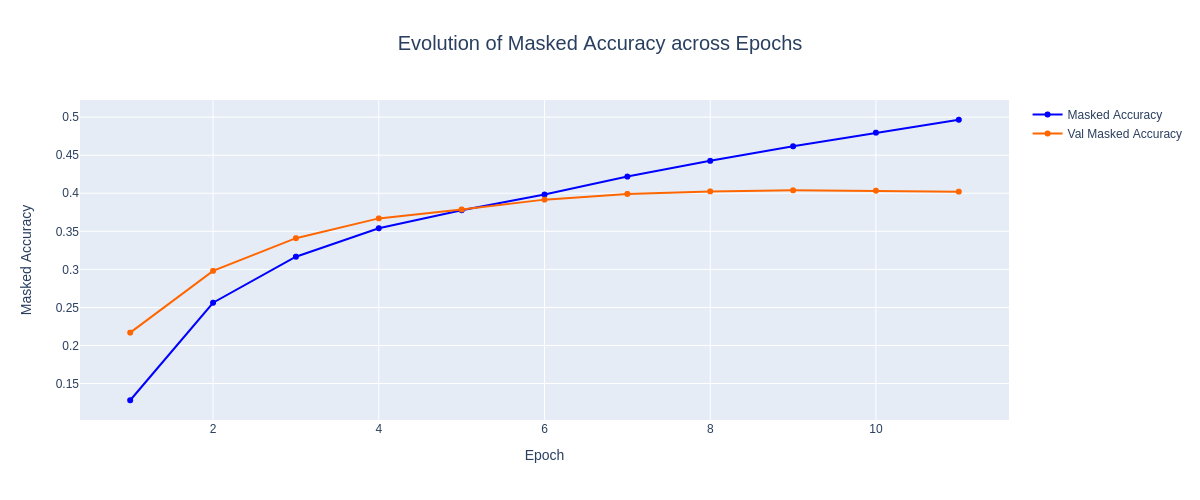

In [ ]:
plot_metrics(renderer="png")
plot_metrics(metric="masked_accuracy", renderer="png")

### **With the ROUGE Metric**

The [Recall-Oriented Understudy for Gisting Evaluation (ROUGE)](https://huggingface.co/spaces/evaluate-metric/rouge) metric is a set of measures used to evaluate the quality of text translation and summarization. It includes several variants, such as ``rouge1``, which measures the overlap of unigrams between the generated summary and the reference summary; ``rouge2``, which evaluates the overlap of bigrams; ``rougeL``, which considers the longest sequence of overlapping tokens; and  ``rougeLsum``, which computes ROUGE-L at the summary level. Additionally, these metrics can be assessed at different levels of granularity, such as ``low``, ``mid``, and ``high``, representing various thresholds of overlap. Each component of the ROUGE metric is evaluated on a scale from 0 to 1, where 1 indicates an exact match between the predictions and the references.


In [ ]:
# Load the trained model
tf.keras.backend.clear_session()

model = tf.keras.models.load_model(
    trained_model_path,
    custom_objects={
        "masked_loss": masked_loss,
        "masked_accuracy": masked_accuracy
    }
)

model.summary()

Model: "Transformer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, None)]               0         []                            
                                                                                                  
 decoder_input (InputLayer)  [(None, None)]               0         []                            
                                                                                                  
 Encoder (Functional)        (None, None, 256)            2174464   ['encoder_input[0][0]']       
                                                          0                                       
                                                                                                  
 Decoder (Functional)        (None, None, 256)            3016089   ['decoder_input[0][0

In [ ]:
# Class for generating summaries

class GenerateSummary():
  def __init__(self, model):
    self.model = model
    self.token_start = list(vocab).index("[START]")
    self.token_end = list(vocab).index("[END]")
    # Mask to discard [UNK] tokens and padding tokens
    self.mask = tf.scatter_nd(
        indices=[[0], [1]],
        updates=[-float("inf"), -float("inf")],
        shape=(vocab_size,)
    )

  @tf.function #Transforming the function into an optimized computational graph to accelerate prediction
  def generate_next_token(self, encoder_input, output):
    logits = self.model([encoder_input, output])
    logits = logits[:, -1, :]
    logits += self.mask
    next_token = tf.cast(tf.argmax(logits, axis=-1), tf.int32)
    return next_token[None, :]

  def summarize(self, text):
    encoder_input = context_tokenizer([text])
    output = tf.constant(self.token_start, shape=(1, 1))

    for _ in range(target_max_length-1):
      next_token = self.generate_next_token(encoder_input, output)
      if next_token == self.token_end:
        break

      output = tf.concat([output, next_token], axis=-1)

    output = " ".join(vocab[output[0, 1:]])
    # Remove extra spaces from punctuation
    output = re.sub(r"\s([.,;:?!])", r"\1", output)
    return output

In [ ]:
generate_summary = GenerateSummary(model)

**Load the Evaluation Metric**

In [5]:
metric = load_metric("rouge")
metric

Metric(name: "rouge", features: {'predictions': Value(dtype='string', id='sequence'), 'references': Value(dtype='string', id='sequence')}, usage: """
Calculates average rouge scores for a list of hypotheses and references
Args:
    predictions: list of predictions to score. Each prediction
        should be a string with tokens separated by spaces.
    references: list of reference for each prediction. Each
        reference should be a string with tokens separated by spaces.
    rouge_types: A list of rouge types to calculate.
        Valid names:
        `"rouge{n}"` (e.g. `"rouge1"`, `"rouge2"`) where: {n} is the n-gram based scoring,
        `"rougeL"`: Longest common subsequence based scoring.
        `"rougeLSum"`: rougeLsum splits text using `"
"`.
        See details in https://github.com/huggingface/datasets/issues/617
    use_stemmer: Bool indicating whether Porter stemmer should be used to strip word suffixes.
    use_aggregator: Return aggregates if this is set to True
Retu

In [ ]:
def normalize_target(text):
  text = preprocessing(text).numpy().decode("utf-8")
  text = " ".join(text.split()[1:-1])
  text = re.sub(r"\s([.,;:?!])", r"\1", text)
  return text

In [ ]:
def prepare_for_evaluation(dataset):
  predictions, references = [], []
  for sample in tqdm(dataset):
    prediction = generate_summary.summarize(sample["document"])
    reference = normalize_target(sample["summary"])

    predictions.append(prediction)
    references.append(reference)

  return predictions, references

In [ ]:
predictions, references = prepare_for_evaluation(dataset["validation"])

  0%|          | 0/11332 [00:00<?, ?it/s]

In [ ]:
result = metric.compute(predictions=predictions, references=references)
result

{'rouge1': AggregateScore(low=Score(precision=0.2910892164337418, recall=0.27071016418746097, fmeasure=0.27431391629885277), mid=Score(precision=0.29379004628100325, recall=0.27312207806767475, fmeasure=0.2766014333505943), high=Score(precision=0.2964024502707517, recall=0.27538887326534156, fmeasure=0.278837118886443)),
 'rouge2': AggregateScore(low=Score(precision=0.08880000911526556, recall=0.08186421505417915, fmeasure=0.08317725786435633), mid=Score(precision=0.09090801396900486, recall=0.08384003111172364, fmeasure=0.08513480105434645), high=Score(precision=0.09294730942677813, recall=0.08572227041588175, fmeasure=0.08700797939015024)),
 'rougeL': AggregateScore(low=Score(precision=0.2340335266913699, recall=0.2181280652825888, fmeasure=0.22067173629174086), mid=Score(precision=0.23640213876400806, recall=0.22024558673652464, fmeasure=0.22273297875644082), high=Score(precision=0.23891715152079496, recall=0.22249297481776278, fmeasure=0.22508273484805905)),
 'rougeLsum': Aggregate

**Overall evaluation results**

In [ ]:
result = {key: value.mid.fmeasure*100 for key, value in result.items()}
result

{'rouge1': 27.660143335059427,
 'rouge2': 8.513480105434645,
 'rougeL': 22.273297875644083,
 'rougeLsum': 22.2800829016142}

The results obtained on the evaluation dataset are as follows: **`rouge1`: 27.66**, **`rouge2`: 8.51**, **`rougeL`: 22.27**, **`rougeLsum`: 22.28**. These values indicate that the model has a low-to-medium quality. As will be shown later, the model generally performs moderately on short texts and poorly on long texts when generating summaries. This performance is likely due to the use of a basic Transformer model for the abstractive summarization task, which is more challenging compared to translation. Additionally, the tokenizer used is very simplified, working at the word level and including only a few important punctuation marks without considering numeric characters. The dataset is also very challenging, with lengthy articles and very concise summaries, suggesting the need for a more robust tokenizer. Of course, similar to translation, ROUGE scores would be higher with multiple references, given that summaries can vary in length and use synonymous words. Finally, it is important to note that even more advanced models, such as **BART Large** fine-tuned on the same XSum dataset, achieved only a [**`rouge1` score of 45.45**](https://huggingface.co/facebook/bart-large-xsum) (not exceeding 50%) on the test dataset, highlighting the complexity of the text summarization task.

## **Generating Summaries with the Trained Model**

In [ ]:
# Function to generate summaries and display them in HTML format

def display_summary(text, reference=None):
  prediction = generate_summary.summarize(text)
  #Replace `\n` with `<br>` to make the line break visible in HTML format
  text = text.replace("\n", "<br>")

  content_html = f"""
  <b>Text:<br></b> {text}<br><br>
  <b>Summary:</b> {prediction}<br><br>
  """

  if reference is not None:
    reference = normalize_target(reference)
    result = metric.compute(predictions=[prediction], references=[reference])
    result = {key: value.mid.fmeasure*100 for key, value in result.items()}

    content_html += f"<b>Reference:</b> {reference}<br><br>"
    for key, value in result.items():
      content_html += f"<b><span style='color: blue'>{key}:</span></b> {round(value, 2)}&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;"

  display(HTML(content_html))

### **Validation Dataset**

In [ ]:
len_data = len(dataset["validation"])

In [ ]:
id = 0
sample = dataset["validation"][id]

display_summary(sample["document"], sample["summary"])

In [ ]:
id = np.random.randint(len_data)
sample = dataset["validation"][id]

display_summary(sample["document"], sample["summary"])

In [ ]:
id = np.random.randint(len_data)
sample = dataset["validation"][id]

display_summary(sample["document"], sample["summary"])

In [ ]:
id = np.random.randint(len_data)
sample = dataset["validation"][id]

display_summary(sample["document"], sample["summary"])

In [ ]:
id = np.random.randint(len_data)
sample = dataset["validation"][id]

display_summary(sample["document"], sample["summary"])

In [ ]:
id = np.random.randint(len_data)
sample = dataset["validation"][id]

display_summary(sample["document"], sample["summary"])

In [ ]:
# Long Text
id = np.random.randint(len_data)
sample = dataset["validation"][id]

display_summary(sample["document"], sample["summary"])

In [ ]:
# Long Text
id = np.random.randint(len_data)
sample = dataset["validation"][id]

display_summary(sample["document"], sample["summary"])

In [ ]:
# Long Text
id = np.random.randint(len_data)
sample = dataset["validation"][id]

display_summary(sample["document"], sample["summary"])

### **Other Texts**

In [ ]:
text = """
Scientists have recently discovered a new species of frog in the Amazon rainforest.
This species, which is characterized by its bright blue skin and unique call, was found
in a remote part of the rainforest that has been largely untouched by human activity.
The discovery is significant as it highlights the rich biodiversity of the Amazon and
underscores the need for conservation efforts to protect these habitats. Researchers are
excited about the potential for further discoveries in this area.
"""

display_summary(text)

In the following example, the limitations of the tokenizer are evident as it removes numerical characters to simplify the vocabulary, leading to inconsistencies in the summary generated by the model.

In [ ]:
text = """
A massive industrial accident at a chemical plant in Texas has resulted in multiple fatalities and injuries.
The explosion occurred in the early hours of the morning, sending shockwaves through the nearby community.
Firefighters and emergency response teams rushed to the scene, battling the blaze and rescuing trapped workers.
Authorities have confirmed that ten people were killed and dozens more injured, some critically. The cause of the
explosion is still under investigation, but initial reports suggest that a gas leak might have ignited the blast.
The incident has raised serious concerns about safety regulations and emergency preparedness at industrial facilities.
Local officials have called for a thorough review of safety protocols to prevent such catastrophic events in the future.
"""

display_summary(text)

In [ ]:
# Long Text
text = """
The issue of global poverty remains one of the most pressing challenges facing the international community.
Despite significant progress in reducing poverty rates over the past few decades, a substantial number of
people around the world continue to live in extreme poverty. Factors contributing to persistent poverty include
inadequate access to education, healthcare, and economic opportunities. Additionally, systemic issues such as corruption,
political instability, and inadequate infrastructure further exacerbate the problem.

Efforts to address global poverty have involved various strategies, including international aid, development programs,
and policy reforms. Organizations such as the United Nations and the World Bank have implemented initiatives aimed at
improving living conditions, increasing access to essential services, and promoting economic development. These initiatives
often focus on areas such as education, healthcare, and job creation, with the goal of empowering individuals and
communities to lift themselves out of poverty.

However, achieving sustainable poverty reduction requires addressing the root causes of poverty and implementing
comprehensive and inclusive policies. This includes promoting good governance, strengthening institutions, and
ensuring that economic growth benefits all segments of society. Additionally, addressing global challenges such
as climate change and inequality is crucial for creating an environment where poverty can be effectively reduced.

The fight against global poverty is ongoing and requires continued commitment and collaboration from governments,
organizations, and individuals. By tackling the underlying causes of poverty and promoting equitable development,
we can work towards a future where all people have the opportunity to live healthy and fulfilling lives. The path
to ending poverty involves a multifaceted approach that considers economic, social, and environmental factors, and
it demands persistent efforts and innovative solutions.
"""

display_summary(text)

In [ ]:
# Long Text
# Incorrect Summary
text = """
The exploration of space has been a focal point of scientific and technological advancements for decades,
driven by the quest to understand our universe and our place within it. Space exploration missions, from early
satellite launches to crewed spaceflights and interplanetary probes, have expanded our knowledge of space and
provided valuable insights into the origins and evolution of celestial bodies. The Hubble Space Telescope, for example,
has offered unprecedented views of distant galaxies and cosmic phenomena, leading to breakthroughs in our understanding of the universe.

Recent missions, such as those conducted by NASA's Mars rovers, have aimed to investigate the potential for
past or present life on Mars. These missions have provided detailed analyses of Martian soil and atmosphere,
revealing clues about the planet's geological history and its potential habitability. Additionally, the discovery
of water ice on Mars has fueled discussions about the feasibility of future human colonization and the broader
implications for space exploration.

In recent years, private companies have also played a significant role in space exploration, with initiatives
such as SpaceX's reusable rockets and Blue Origin's suborbital flights. These advancements have reduced the
cost of accessing space and opened new possibilities for commercial ventures, including space tourism and asteroid mining.

As we look to the future, space exploration presents both exciting opportunities and challenges. The development
of advanced propulsion technologies, international collaboration, and sustainable practices will be essential for
the continued progress of space exploration. Understanding the broader implications of our activities in space,
including their impact on Earth and potential ethical considerations, will be crucial for ensuring that our
exploration efforts contribute positively to humanity's long-term goals.
"""

display_summary(text)

**Conclusion:** The model can achieve medium to high performance when summarizing short texts despite the limitations of the tokenizer. However, its performance is poor for long texts, often producing incoherent or irrelevant summaries. To achieve better results, the measures mentioned in the Model Evaluation section should be implemented. In my next [notebook](https://github.com/JersonGB22/Summarization-TensorFlow/blob/main/models/Summarization_T5_XSum.ipynb), the T5 model is fine-tuned using the same XSum dataset, yielding better results.